In [1]:
%load_ext rpy2.ipython
%R library(ggplot2)
%R library(scales)

import pandas as pd
import numpy as np

In [2]:
def pd2r(df):
    # For all columns with dtype = object (i.e. mixed dtypes)
    # Replace all NA's and NaN's with None
    df.loc[:, df.dtypes == object] = df.loc[:, df.dtypes == object].where((pd.notnull(df)), None)
    return df

In [3]:
nba_pow = pd2r(pd.read_csv('../data/raw/NBA_Player_of_the_Week.csv'))
nba_pow.head()

,Active season,Player,Team,Conference,Date,Position,Height,Weight,Age,Draft Year,Seasons in league,Season,Season short,Real_value
0,0,Micheal Ray Richardson,New Jersey Nets,None,"Apr 14, 1985",PG,6-5,189,29,1978,6,1984-1985,1985,1.0
1,0,Derek Smith,Los Angeles Clippers,None,"Apr 7, 1985",SG,6-6,205,23,1982,2,1984-1985,1985,1.0
2,0,Calvin Natt,Denver Nuggets,None,"Apr 1, 1985",F,6-6,220,28,1979,5,1984-1985,1985,1.0
3,0,Kareem Abdul-Jabbar,Los Angeles Lakers,None,"Mar 24, 1985",C,7-2,225,37,1969,15,1984-1985,1985,1.0
4,0,Larry Bird,Boston Celtics,None,"Mar 17, 1985",SF,6-9,220,28,1978,5,1984-1985,1985,1.0


In [4]:
nba_pow_agg = nba_pow.groupby(['Player', 'Season short'])[['Date']].count().reset_index().rename(columns = {'Season short': 'Year', 'Date': 'Pow_Count'})
nba_pow_agg.head()

,Player,Year,Pow_Count
0,Aaron McKie,2001,1
1,Adrian Dantley,1986,1
2,Al Harrington,2009,1
3,Al Horford,2013,1
4,Al Horford,2015,2


In [5]:
nba_player_stats = pd2r(pd.read_csv('../data/scraped/NBA_Player_Stats.csv'))
nba_player_stats.head()

,Year,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1985,Kareem Abdul-Jabbar,C,37.0,LAL,79,79,33.3,9.2,15.3,...,0.732,2.1,5.8,7.9,3.2,0.8,2.1,2.5,3.0,22.0
1,1985,Alvan Adams,PF,30.0,PHO,82,69,26.0,5.8,11.2,...,0.883,1.9,4.2,6.1,3.8,1.4,0.6,2.4,3.1,14.7
2,1985,Mark Aguirre,SF,25.0,DAL,80,79,33.7,9.9,19.6,...,0.759,2.4,3.6,6.0,3.1,0.8,0.3,3.2,3.1,25.7
3,1985,Danny Ainge,SG,25.0,BOS,75,73,34.2,5.6,10.6,...,0.868,1.0,2.6,3.6,5.3,1.6,0.1,2.0,3.0,12.9
4,1985,Chuck Aleksinas,C,25.0,GSW,74,4,15.1,2.2,4.6,...,0.733,1.2,2.5,3.6,0.5,0.2,0.2,1.0,2.3,5.1


In [6]:
nba_player = pd.merge(left = nba_player_stats, right = nba_pow_agg, on = ['Player', 'Year'], how = 'left')
nba_player.Pow_Count = nba_player.Pow_Count.where((pd.notnull(nba_player.Pow_Count)), 0)

In [7]:
nba_player['MP_Prct'] = nba_player['MP'] / 48
nba_player['eFG_Prct'] = nba_player['eFG%']
nba_player['isPow'] = np.where(nba_player['Pow_Count'] > 1, 'Yes', 'No')
nba_player_pow = nba_player.groupby(['Year', 'isPow']).agg({'MP_Prct': 'mean', 'eFG_Prct': 'mean'}).reset_index()
nba_player_pow.head()

,Year,isPow,MP_Prct,eFG_Prct
0,1985,No,0.414444,0.461025
1,1985,Yes,0.756250,0.508500
2,1986,No,0.411083,0.458043
3,1986,Yes,0.788021,0.519250
4,1987,No,0.415337,0.462411


In [8]:
%R -i nba_player_pow

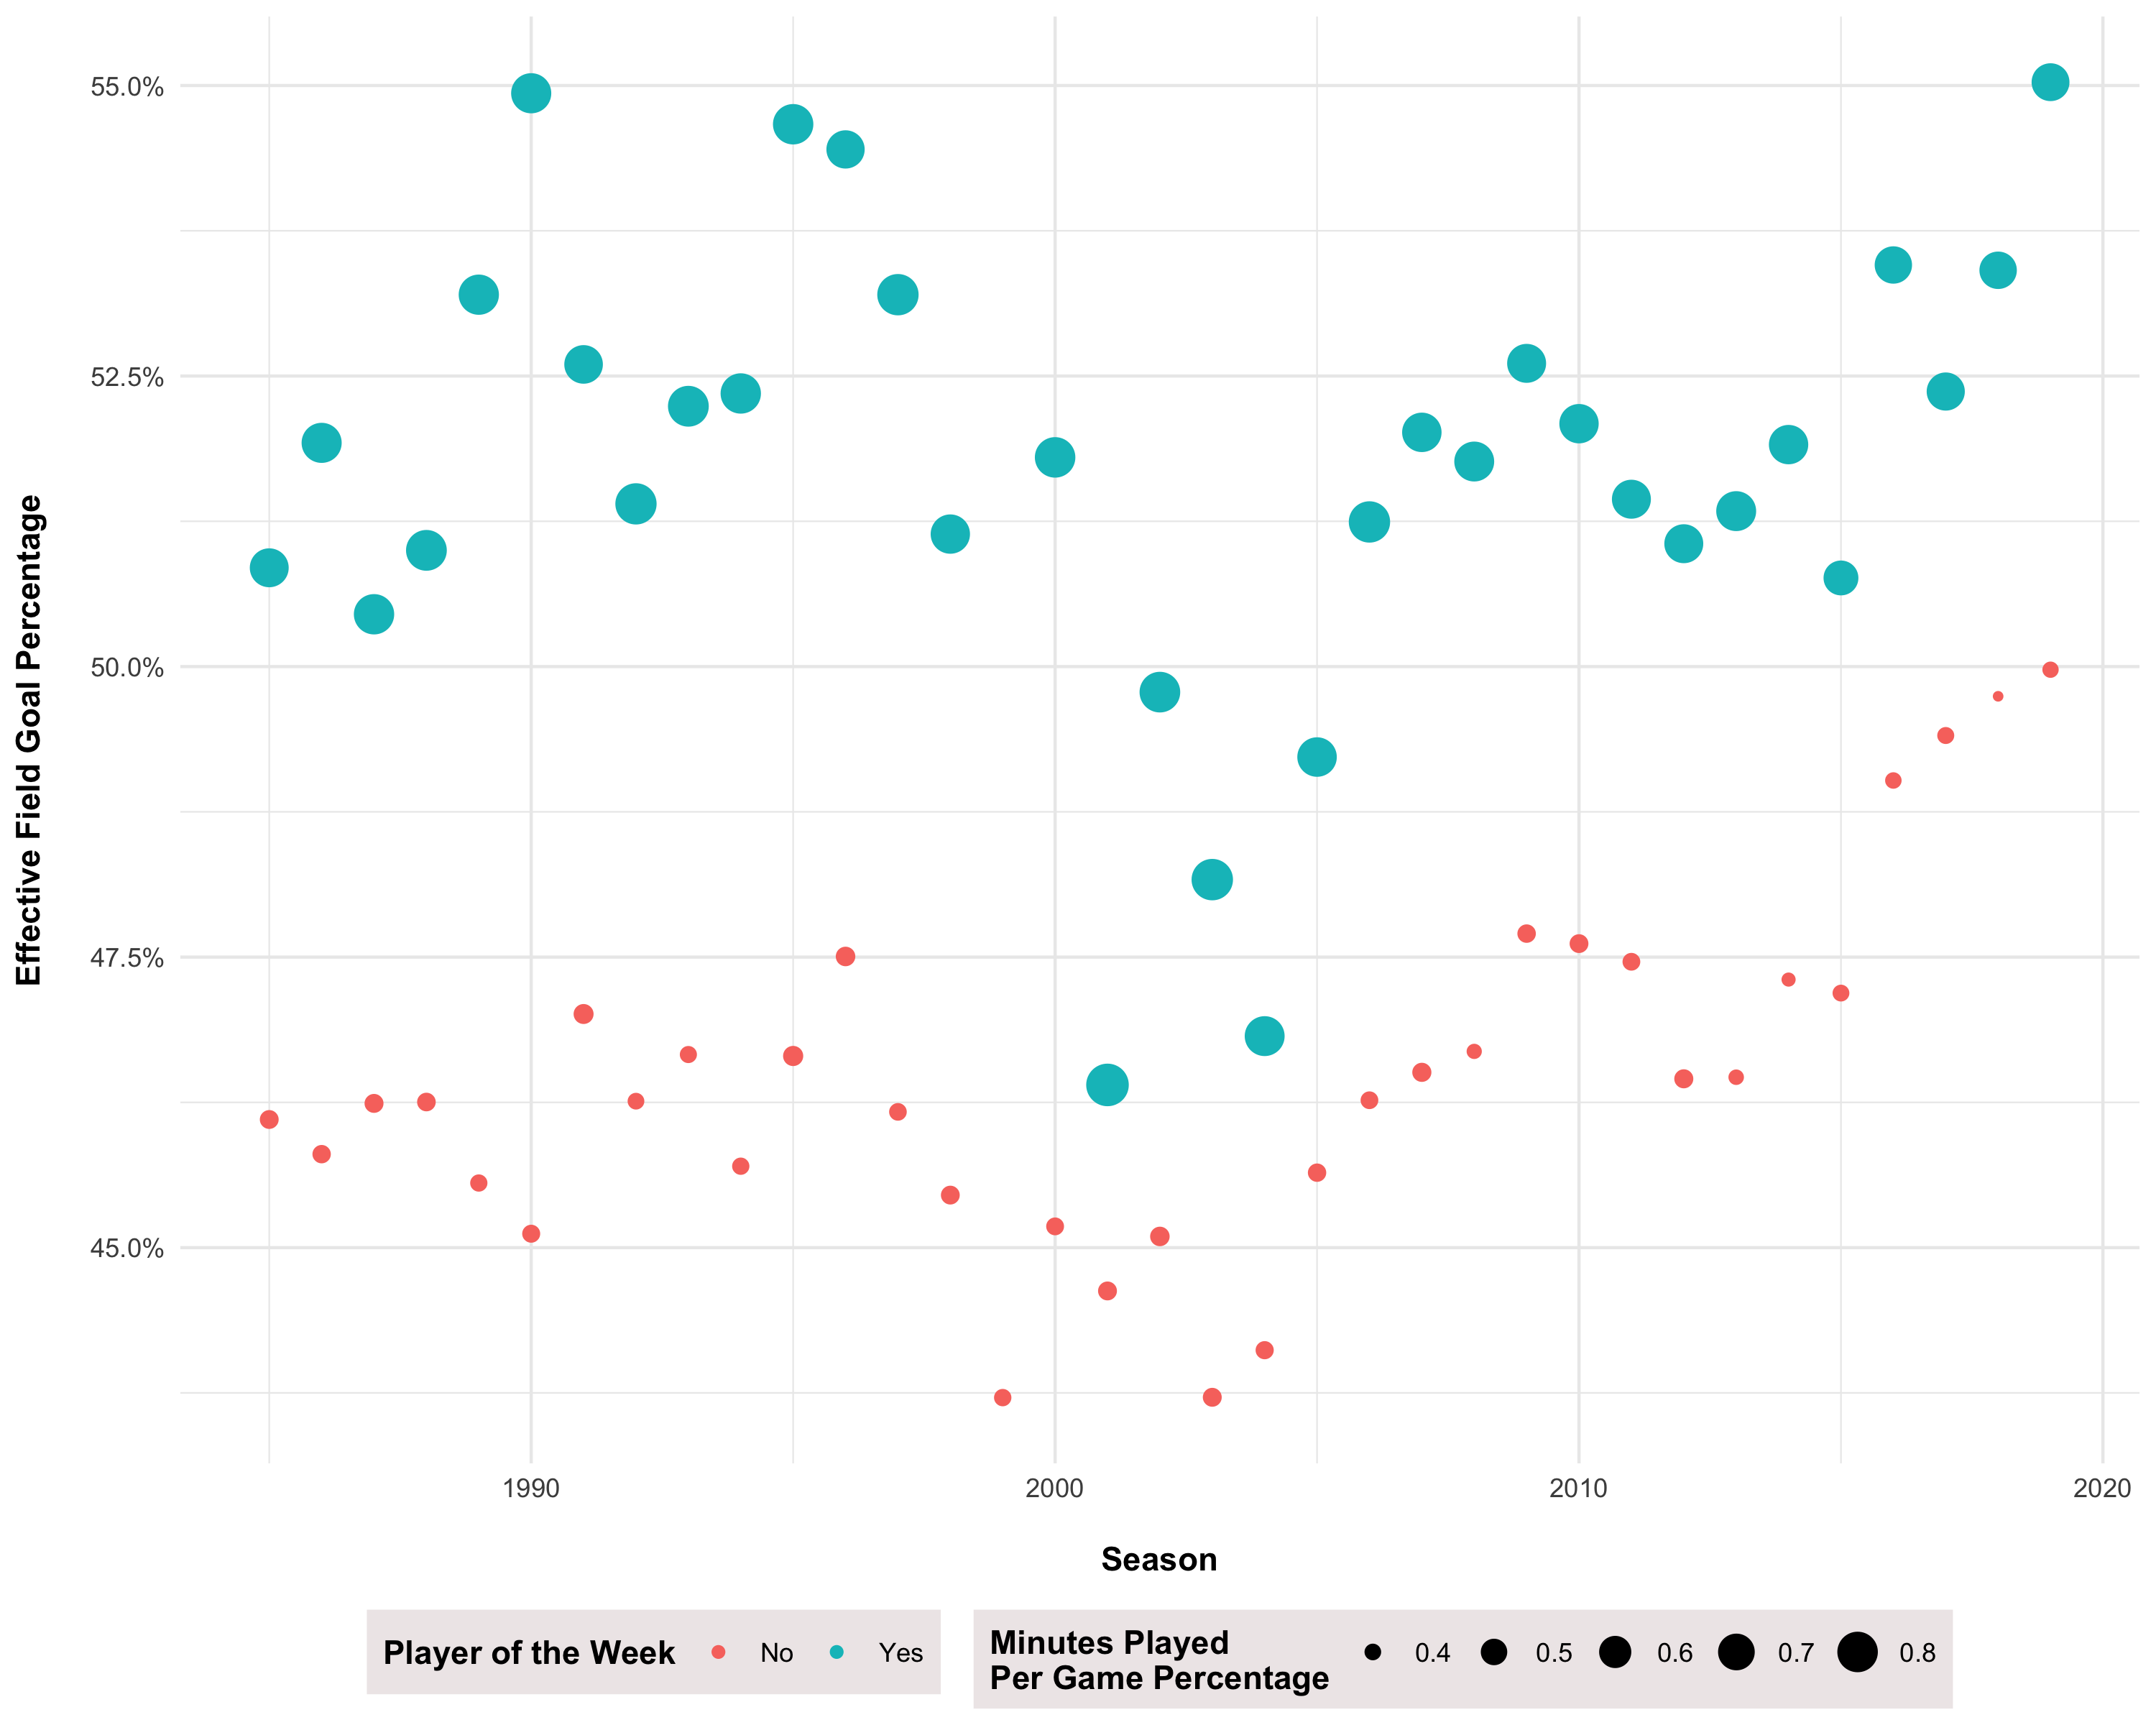

In [9]:
%%R -w 10 -h 8 --units in -r 300
ggplot() +
geom_point(aes(x = Year, y = eFG_Prct, size = MP_Prct, color = isPow), data = nba_player_pow) +
scale_x_continuous(name = '\nSeason') +
scale_y_continuous(name = 'Effective Field Goal Percentage\n', label = percent) +
scale_size_continuous(name = 'Minutes Played\nPer Game Percentage') +
scale_color_discrete(name = 'Player of the Week') +
theme_minimal() +
theme(axis.title = element_text(face = 'bold'),
      legend.title = element_text(face = 'bold'),
      legend.position = 'bottom',
      legend.background = element_rect(size = 0, fill = 'snow2'))